In [1]:
import os
import sys
import skimage

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import time

PKG_DIR = "./"
# PKG_DIR = "/project/bioinformatics/Xiao_lab/s181141/Packages"
sys.path.append(PKG_DIR)

from DIPModels.unet import model as unet_model
from DIPModels.unet import config as unet_config
from DIPModels.unet import utils as unet_utils

from DIPModels.utils_g import utils_image
from DIPModels.utils_g import utils_keras
from DIPModels.utils_g import utils_misc

from utils_nuclei import *

%matplotlib inline 
%load_ext autoreload

#import warnings;
#warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
%autoreload 2
## Load training config and model
MODEL_DIR = "./UNet2D_logs/"
training_config = unet_config.Config(
    NAME='nuclei', 
    NUM_CLASSES=5,
    MODEL_INPUT_SIZE=(512, 512),
    
    ENCODER = 'ResNet',
    #FILTER_SIZE=[4, 8, 16],
    ENCODER_USE_BN = True,
    ARCHITECTURE = 'resnet101',
    
    DECODER = 'UNet',
    UPSAMPLING_MODE = 'nearest',
    DECODER_USE_BN = True,
    
    DROPOUT_RATE=0.0,
    
    # batch_size = gpu_count * images_per_gpu
    GPU_COUNT=1,
    IMAGES_PER_GPU=3,
    VALIDATION_STEPS=None, 
    STEPS_PER_EPOCH=None,
    LEARNING_RATE=1e-4, # for adam
)
training_config.display()

# Load pre-trained weights
ZF_MODEL_PATH = os.path.join(PKG_DIR, "./pretrained/mask_rcnn_balloon.h5")
LAST_MODEL = os.path.join(MODEL_DIR, "nuclei_ResNet_UNet20180816T1017", "nuclei_ResNet_UNet_0100.h5")

weights_path = LAST_MODEL
model = unet_model.UNet(model_dir=MODEL_DIR, config=training_config, weights_path=None)
model.load_weights(layers=r".*", weights_path=weights_path, by_name=True)
#model.load_weights(layers=r"^(?!((decoder\_)|(bg_logits)|(cl_logits))).*", weights_path=weights_path, 
#                   by_name=True, skip_mismatch=False, reshape=False)
model.keras_model.summary()


Configurations:
ARCHITECTURE                   resnet101
BATCH_SIZE                     3
DECODER                        UNet
DECODER_USE_BN                 True
DROPOUT_RATE                   0.0
ENCODER                        ResNet
ENCODER_USE_BN                 True
FILTER_SIZE                    (32, 64, 128, 256, 512, 1024)
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   [1. 1.]
MODEL_INPUT_SIZE               (512, 512)
NAME                           nuclei
NUM_CLASSES                    5
STEPS_PER_EPOCH                None
UPSAMPLING_MODE                nearest
VALIDATION_STEPS               None
WEIGHT_DECAY                   0.0001


Loading weights from: ./UNet2D_logs/nuclei_ResNet_UNet20180816T1017/nuclei_ResNet_UNet_0100.h5
_______________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


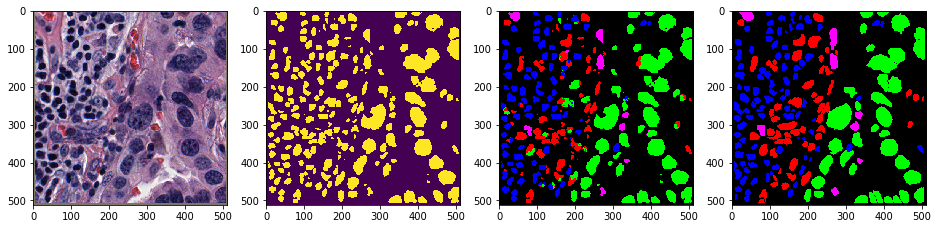

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


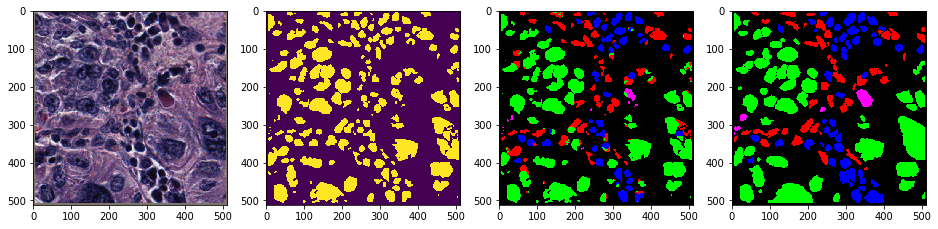

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


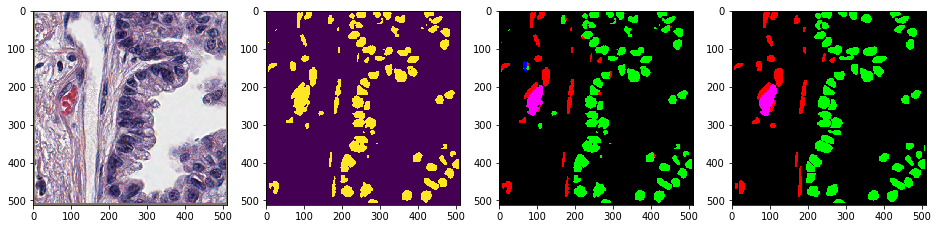

In [ ]:
valid_dir = "./data/"
dataset_valid = unet_model.dataset(training_config,valid_dir,dtype='val')
val_sequence = unet_model.DataSequence(dataset_valid, batch_size=3, # training_config.BATCH_SIZE,
                                         config=training_config,
                                         use_border_weights=False, use_class_weights=False,
                                         border_weights_sigma=32,
                                         shuffle=False)

k = 0
for x, (y1, y2) in val_sequence:
    k += 1
    if k > 10:
        break
        
    labels, bg_scores, cl_scores = model.detect(x*1.0)
    fig, axes = plt.subplots(1, 4, figsize=[4 * 4, 4], sharex=False, sharey=False)
    ax = axes.ravel()
    ax[0].imshow((x[0]+utils_keras.IMAGE_NET_MEAN)/255)
    #ax[1].imshow(labels[0])
    ax[1].imshow(np.argmax(bg_scores[0], axis=-1))
    
    mask_pred = np.zeros((512, 512, 3))
    mask_true = np.zeros((512, 512, 3))
    for i in range(512):
        for j in range(512):
            class_labels = np.argmax(y1[0], axis=-1) * (np.argmax(y2[0], axis=-1) + 1)
            if labels[0][i,j] != 0:
                mask_pred[i,j] = np.array(dataset_valid.class_colors[labels[0][i,j]])
            if class_labels[i,j] != 0:
                mask_true[i,j] = np.array(dataset_valid.class_colors[class_labels[i,j]])
    ax[2].imshow(mask_pred)
    ax[3].imshow(mask_true)
    #ax[3].imshow(np.argmax(cl_scores[0], axis=-1) + 1)
    #ax[3].imshow(cl_scores[0])
    plt.show()

In [ ]:
np.unique(cl_scores[0]*np.array([1,2,3,4]))

In [ ]:
np.unique((np.argmax(cl_scores[0], axis=-1)+1))